# Key notes

* Presents a simple interpretation of the actor-critic framework by expressing a PID controller as a shallow neural network. The PID gains are the weights of the actor network. The critic is the Q-function associated with the actor, and is parameterized by a DNN. Then extend interpretation to include input saturation, making the actor a simple nonlinear controller. Input saturation can lead to integral windup; therefore incorporate a new tuning parameter for anti-windup compensation. Finally, the simplicity of the actor network allows us to initialize training with hand-picked PID gains. **The actor is therefore initialized as an operational, interpretable, and industrially accepted controller that is then updated in an optimal direction after each roll-out (episode) in the plant**.
* 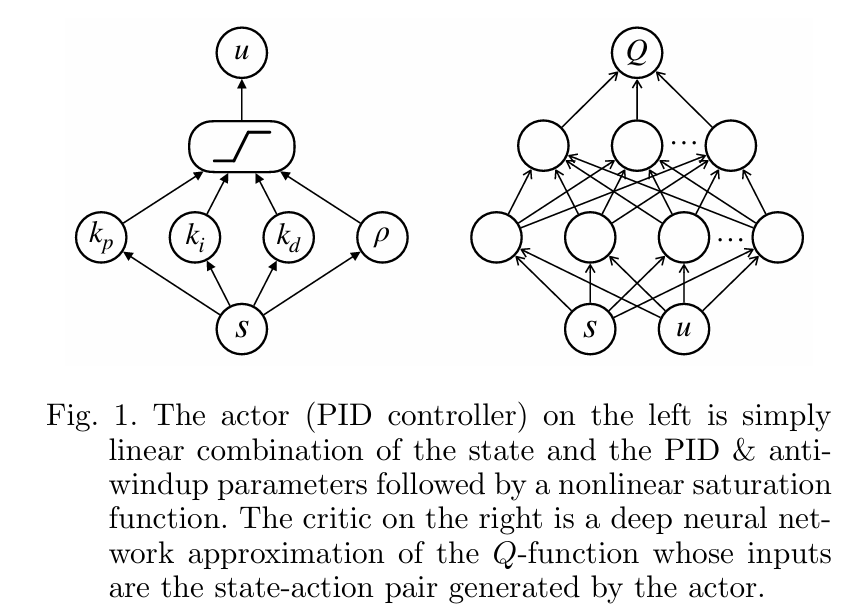
* Actor-Critic Initialization
  An advantage of the approach is that the weights for the actor can be initialized with hand-picked PID gains. For example, if a plant is operating with known gains $k_p, k_i, k_d$, then these can be used to initialize the actor. The idea is that these gains will be updated by stochastic gradient ascent in the approximate direction leading to the greatest expected reward. The quality of the gain updates then relies on the quality of the $Q-function$. The $Q-function$ is parameterized by a deep neural network and is therefore initialized randomly. Both the actor and critic parameters are updated after each roll-out with the environment. However, depending on the number of time-steps in each roll-out, this can lead to slow learning. Therefore, we continually update the critic during the roll-out using batch data from RM. 

# Replay Memory (RM)

Replay Memory is a technique used in RL to store and reuse past experiences. It involves maintaining a fixed-size collection of tuples, each representing a state, action, next state, and reward. This allows the RL agent to learn from past experiences by sampling and replaying them during training, which improves the stability and efficiency of the learning process. 

In this paper, RM is used to enhance the training of PID controller within the actor-critic framework. Here are the advantages:

1. Improved Sample Efficiency: By reusing past experiences stored in RM, the RL algorithm can learn more effectively from a limited amount of data.
2. Stabilized Learning Process: RM helps in stabilizing the learning process by breaking the correlation between consecutive experiences, which is crucial for the convergence of deep RL algorithms.
3. Enhanced Performance: The use of RM allows for better performance of the PID controller by enabling more accurate updates to the controller parameters based on a diverse set of past experiences.


# Try to replicate results

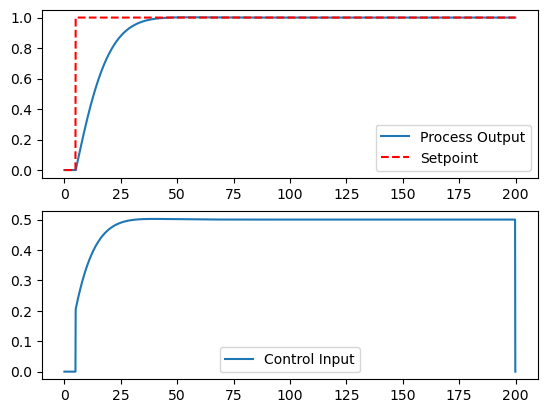

In [1]:
# Example 1 simulation

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete, tf2ss

def simulate_process(total_time=200, dt=0.1, step_time=5.0):
    # 1) Continuous-time transfer function
    num = [2.0]
    den = [6.0, 1.0]

    # 2) Convert transfer function -> continuous-time state-space
    A_c, B_c, C_c, D_c = tf2ss(num, den)

    # 3) Discretize the state-space system via ZOH
    #    sysd will be (A, B, C, D, dt)
    sysd = cont2discrete((A_c, B_c, C_c, D_c), dt=dt, method='zoh')
    A, B, C, D, _ = sysd

    # Time vector
    time = np.arange(0, total_time, dt)
    n_steps = len(time)

    # Simple step setpoint: 0 for t < step_time, then 1
    setpoint = np.zeros(n_steps)
    step_index = int(step_time / dt)
    setpoint[step_index:] = 1.0

    # Prepare arrays
    control_input = np.zeros(n_steps)
    measurements = np.zeros(n_steps)

    # Simple PI gains (just placeholders)
    Kp = 0.2
    Ki = 0.05
    integral = 0.0

    # State vector for the discrete system
    x = np.array([0.0])  # 1D if your system is first-order

    for k in range(n_steps - 1):
        # 1) Controller
        error = setpoint[k] - measurements[k]
        integral += error * dt
        u = Kp * error + Ki * integral
        control_input[k] = u

        # 2) Plant update: x[k+1] = A x[k] + B u[k]
        x_next = A @ x + B * u
        #    output y[k+1] = C x[k+1] + D u[k]
        y_next = (C @ x_next + D * u).item()

        x = x_next
        measurements[k+1] = y_next

    return time, setpoint, measurements, control_input

# --- Example usage ---
if __name__ == "__main__":
    t, sp, meas, ctrl = simulate_process()
    # Plot
    plt.subplot(2,1,1)
    plt.plot(t, meas, label="Process Output")
    plt.plot(t, sp, 'r--', label="Setpoint")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(t, ctrl, label="Control Input")
    plt.legend()
    plt.show()


## Step 1: Define PID controller with anti-windup 

In [2]:
import numpy as np

class PIDController:
    def __init__(self, kp, ki, kd, dt):
        """
        Basic PID Controller without saturation or anti-windup
        """
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt # time step

        self.integral = 0.0
        self.prev_error = 0.0

    def update(self, setpoint, measurement):
        """
        compute the PID control law:
            u = Kp * e + Ki * integral(e) + Kd * derivative(e).
        """
        error = setpoint - measurement
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt

        output = self.kp * error + self.ki * self.integral + self.kd * derivative
        self.prev_error = error

        return output

class PIDControllerWithAntiWindup(PIDController):
    def __init__(self, kp, ki, kd, dt, umin, umax, rho):
        """
        PID controller with saturation and a simple back-calculation anti-windup method.
        """
        super().__init__(kp, ki, kd, dt)
        self.umin = umin
        self.umax = umax
        self.rho = rho  # Anti-windup parameter

    def update(self, setpoint, measurement):
        error = setpoint - measurement
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt

        # "Unsaturated" output
        unsat_output = self.kp * error + self.ki * self.integral + self.kd * derivative
        # Apply saturation
        output = max(self.umin, min(unsat_output, self.umax))

        # Anti-windup back-calculation
        if self.ki != 0:
            # If output is clipped, offset the integrator
            self.integral += self.rho * (output - unsat_output) / self.ki

        self.prev_error = error
        return output

## Step 2: A Quick Test of the Anti-Windup Controller

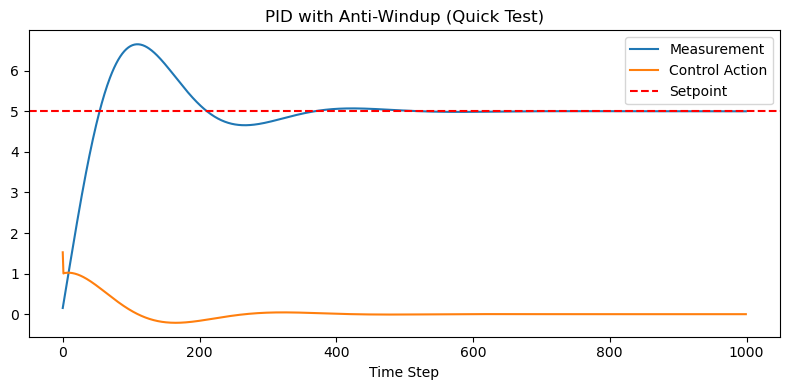

In [13]:
import matplotlib.pyplot as plt

def simulate_process(controller, setpoint, steps):
    """
    Simple open-loop simulation of a process y[k+1] = y[k] + 0.1 * u[k].
    The factor 0.1 is an arbitrary "gain" to see how the system responds.
    """
    measurement = 0.0
    measurements = []
    controls = []

    for _ in range(steps):
        control_action = controller.update(setpoint, measurement)
        # "Process" update: y[k+1] = y[k] + 0.1*u[k]
        measurement += 0.1 * control_action

        controls.append(control_action)
        measurements.append(measurement)

    return measurements, controls


# Quick standalone test
if __name__ == "__main__":
    pid_aw = PIDControllerWithAntiWindup(kp=0.2, ki=0.05, kd=0.01, 
                                         dt=0.1, umin=-2, umax=2, rho=0.1)

    setpoint = 5.0
    steps = 1000

    meas, ctrl = simulate_process(pid_aw, setpoint, steps)

    plt.figure(figsize=(8,4))
    plt.plot(meas, label='Measurement')
    plt.plot(ctrl, label='Control Action')
    plt.axhline(setpoint, color='r', linestyle='--', label='Setpoint')
    plt.legend()
    plt.xlabel("Time Step")
    plt.title("PID with Anti-Windup (Quick Test)")
    plt.tight_layout()
    plt.show()


## Step 3: Create a Gym-style Environment

### 3a). Import modules

In [14]:
import gymnasium as gym
from gymnasium import spaces

### 3b) Define the environment

In [15]:
class PIDEnv(gym.Env):
    """
    Minimal environment that treats the PID gains (Kp, Ki) as 'actions'.
    Then simulates 1 step of a simple process to produce a reward.
    
    Warning: This is just a demonstration and not necessarily stable or 
    representative of a real RL environment with full episodes, resets, etc.
    """
    metadata = {"render_modes": ["console"]}

    def __init__(self, controller, setpoint=1.0, total_time=5.0, dt=0.1):
        super(PIDEnv, self).__init__()
        self.controller = controller
        self.setpoint = setpoint
        self.dt = dt

        self.steps = int(total_time / dt)
        self.current_step = 0
        self.done = False

        # For now, let's store a separate 'process measurement'.
        self.measurement = 0.0

        # Define action space: changes in Kp, Ki
        # e.g. each in [-0.1, +0.1]
        self.action_space = spaces.Box(
            low=np.array([-0.1, -0.01]), 
            high=np.array([0.1, 0.01]),
            dtype=np.float32
        )

        # Define observation space: let's track [error, integrator]
        # or [measurement, integrator], etc.
        # We'll just track [error, integral] for demonstration.
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf]),
            high=np.array([+np.inf, +np.inf]),
            dtype=np.float32
        )

        # We'll initialize the state in reset()
        self.state = None

    def step(self, action):
        """
        Apply 'action' as incremental changes to Kp, Ki.
        Then take 1 step of the process, compute reward, etc.
        
        Returns: (state, reward, done, truncated, info)
          per Gymnasium's API
        """
        # 1) Unpack the action
        kp_change, ki_change = action

        # 2) Update the controller gains
        self.controller.kp += float(kp_change)
        self.controller.ki += float(ki_change)

        # 3) Step the environment by 1 iteration
        control_action = self.controller.update(self.setpoint, self.measurement)
        # For demonstration: process eqn is y[k+1] = y[k] + 0.1 * u[k]
        self.measurement += 0.1 * control_action

        # 4) Compute next state = [error, integral]
        error = self.setpoint - self.measurement
        self.state = np.array([error, self.controller.integral], dtype=np.float32)

        # 5) Compute reward; here we penalize squared error
        reward = - (error ** 2)

        # 6) Check termination
        self.current_step += 1
        truncated = False
        if self.current_step >= self.steps:
            self.done = True
            truncated = True  # or `terminated = True`, depending on your definition

        info = {}
        return self.state, reward, self.done, truncated, info

    def reset(self, *, seed=None, options=None):
        """
        Resets the environment state, controller integral, etc.
        Returns initial observation.
        """
        super().reset(seed=seed)

        self.current_step = 0
        self.done = False

        # Reset controller's internal states
        self.controller.integral = 0.0
        self.controller.prev_error = 0.0

        # Start with measurement = 0
        self.measurement = 0.0

        # State = [error, integral]
        error = self.setpoint - self.measurement
        self.state = np.array([error, self.controller.integral], dtype=np.float32)

        return self.state, {}
    
    def render(self, mode='console'):
        if mode == 'console':
            print(f"Step: {self.current_step}, State: {self.state}, Kp={self.controller.kp}, Ki={self.controller.ki}")


## Step 4: Building the DDPG Structures in pytorch

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

### 4a) Actor-Critic Networks

In [17]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 400)
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, action_dim)

        self.max_action = max_action

    def forward(self, state):
        a = torch.relu(self.layer1(state))
        a = torch.relu(self.layer2(a))
        # Tanh to get outputs in [-1, +1], then scale by max_action
        return self.max_action * torch.tanh(self.layer3(a))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 400)
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, 1)

    def forward(self, state, action):
        state_action = torch.cat([state, action], dim=1)
        q = torch.relu(self.layer1(state_action))
        q = torch.relu(self.layer2(q))
        q = self.layer3(q)
        return q


### 4b) Replay Buffer

In [18]:
class ReplayBuffer:
    def __init__(self, max_size=1e5):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        # data = (state, next_state, action, reward, done)
        if len(self.storage) < self.max_size:
            self.storage.append(data)
        else:
            # Overwrite in a circular manner if full
            self.storage[self.ptr] = data
            self.ptr = (self.ptr + 1) % self.max_size

    def sample(self, batch_size):
        idxs = np.random.randint(0, len(self.storage), size=batch_size)
        s, s2, a, r, d = [], [], [], [], []
        for i in idxs:
            S, S2, A, R, D = self.storage[i]
            s.append(S)
            s2.append(S2)
            a.append(A)
            r.append(R)
            d.append(D)
        return (
            np.array(s),
            np.array(s2),
            np.array(a),
            np.array(r).reshape(-1,1),
            np.array(d).reshape(-1,1),
        )


## Step 5: Assemble & Training Loop

Episode 1, Reward: -26.47
Episode 2, Reward: -41.37
Episode 3, Reward: -68.77
Episode 4, Reward: -63.09
Episode 5, Reward: -41.65


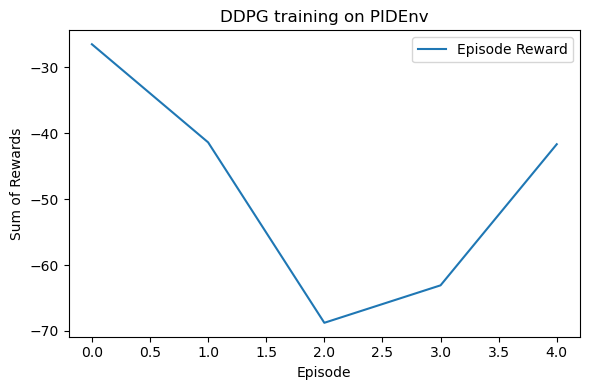

In [23]:
import torch
import torch.nn.functional as F

# Hyperparameters
state_dim = 2   # [error, integral]
action_dim = 2  # [delta_kp, delta_ki]
max_action = 0.1  # We will scale the final layer by 0.1

batch_size = 256
discount = 0.99
tau = 0.005
learning_rate_actor = 1e-3
learning_rate_critic = 1e-3

# Create the networks
actor = Actor(state_dim, action_dim, max_action)
critic = Critic(state_dim, action_dim)
target_actor = Actor(state_dim, action_dim, max_action)
target_critic = Critic(state_dim, action_dim)

# Copy weights from actor->target_actor, critic->target_critic
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

# Optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate_actor)
critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate_critic)

# Replay buffer
replay_buffer = ReplayBuffer(max_size=1e5)

def update_parameters():
    # Sample a batch of transitions
    s, s2, a, r, d = replay_buffer.sample(batch_size)

    state = torch.FloatTensor(s)
    next_state = torch.FloatTensor(s2)
    action = torch.FloatTensor(a)
    reward = torch.FloatTensor(r)
    done = torch.FloatTensor(d)

    # Compute target Q
    with torch.no_grad():
        next_action = target_actor(next_state)
        target_Q = target_critic(next_state, next_action)
        target_Q = reward + (1 - done) * discount * target_Q

    # Optimize Critic
    current_Q = critic(state, action)
    critic_loss = F.mse_loss(current_Q, target_Q)
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    # Optimize Actor (policy gradient)
    actor_loss = -critic(state, actor(state)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    # Soft update of target networks
    for param, target_param in zip(critic.parameters(), target_critic.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    for param, target_param in zip(actor.parameters(), target_actor.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

# ----- Now create the environment and run training -----

if __name__ == "__main__":

    # Instantiate a simpler PID controller (no anti-windup needed in this example)
    base_pid = PIDController(kp=0.2, ki=0.05, kd=0.1, dt=0.1)
    env = PIDEnv(controller=base_pid, setpoint=1.0, total_time=5.0, dt=0.1)

    num_episodes = 5
    exploration_noise = 0.01  # standard deviation for exploration
    episode_length = 50  # how many steps we run in each episode

    rewards_history = []

    for ep in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0.0

        for t in range(episode_length):
            # Actor chooses an action
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0)  # shape [1, state_dim]
            action_tensor = actor(obs_tensor).detach()
            action_np = action_tensor.cpu().numpy()[0]

            # Add exploration noise
            action_np += np.random.normal(0, exploration_noise, size=action_dim)
            # Clip to environment's action space
            action_clipped = np.clip(action_np, env.action_space.low, env.action_space.high)

            # Step the environment
            next_obs, reward, done, truncated, _ = env.step(action_clipped)

            # Save transition
            replay_buffer.add((obs, next_obs, action_clipped, reward, float(done)))

            obs = next_obs
            episode_reward += reward

            # If enough samples, update networks
            if len(replay_buffer.storage) > batch_size:
                update_parameters()

            if done or truncated:
                break

        rewards_history.append(episode_reward)
        print(f"Episode {ep+1}, Reward: {episode_reward:.2f}")

    # Plot the reward over episodes
    plt.figure(figsize=(6,4))
    plt.plot(rewards_history, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards")
    plt.title("DDPG training on PIDEnv")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Another one

In [24]:
# PID Controller (PI only) and simple anti-windup
import numpy as np

class PIController:
    def __init__(self, kp, ki, dt, umin=-np.inf, umax=np.inf, aw_gain=0.0):
        """
        PI controller with optional saturation (umin, umax) and
        a simple anti-windup back-calculation if aw_gain>0.
        """
        self.kp = kp
        self.ki = ki
        self.dt = dt
        self.umin = umin
        self.umax = umax
        self.aw_gain = aw_gain

        self.integral = 0.0
        self.prev_error = 0.0

    def update(self, setpoint, measurement):
        """
        PI control law: u = Kp*e + Ki*∫e dt.
        With optional saturation and anti-windup.
        """
        error = setpoint - measurement

        # Integrate
        self.integral += error * self.dt
        unsat_u = self.kp * error + self.ki * self.integral

        # Saturate
        u = max(self.umin, min(unsat_u, self.umax))

        # Anti-windup adjustment
        if self.aw_gain > 0 and self.ki != 0:
            self.integral += self.aw_gain * (u - unsat_u) / self.ki

        self.prev_error = error
        return u


In [25]:
# Discrete time delay + 1st order plant
class DelayedFirstOrderPlant:
    """
    Discrete approximation of: 
       G(s) = (2 e^{-s}) / (6 s + 1),
    with a sampling time dt=0.1 and a 10-step pure delay.
    
    x[k+1] = alpha * x[k] + beta * u_buffer[ oldest ]
    y[k]   = x[k]
    """
    def __init__(self, dt=0.1):
        self.dt = dt
        self.delay_steps = int(1.0 / dt)  # 1 second / 0.1 = 10 steps
        self.buffer = [0.0]*self.delay_steps  # ring buffer for delayed inputs
        self.ptr = 0  # write/read index

        # The first-order system terms
        self.alpha = 1.0 - (dt/6.0)
        self.beta  = (2.0*dt)/6.0

        self.x = 0.0  # system state

    def reset(self):
        self.buffer = [0.0]*self.delay_steps
        self.ptr = 0
        self.x = 0.0

    def step(self, u):
        """
        1) Store current input u in ring buffer.
        2) Next input to the system is the oldest buffered value.
        3) Update x[k+1], output = x[k+1].
        """
        self.buffer[self.ptr] = u
        # The delayed input is the one from 10 steps ago
        delayed_input = self.buffer[(self.ptr + 1) % self.delay_steps]

        # Move ring buffer pointer
        self.ptr = (self.ptr + 1) % self.delay_steps

        # First-order system update
        self.x = self.alpha*self.x + self.beta*delayed_input
        return self.x  # output


In [26]:
# Gym env for RL
import gymnasium as gym
from gymnasium import spaces

class PIDDelayEnv(gym.Env):
    """
    A minimal environment for RL-based tuning of PI gains 
    on the delayed first-order system G(s)=2e^{-s}/(6s+1), dt=0.1.
    """
    metadata = {"render_modes": ["console"]}

    def __init__(self, 
                 base_controller,       # PIController instance
                 setpoint=1.0, 
                 total_time=20.0, 
                 dt=0.1):
        super().__init__()
        self.controller = base_controller
        self.setpoint   = setpoint
        self.dt         = dt

        self.plant = DelayedFirstOrderPlant(dt=self.dt)
        self.steps_per_episode = int(total_time/dt)
        self.current_step = 0
        self.done = False

        # Action = [dKp, dKi] in some small range
        self.action_space = spaces.Box(
            low=np.array([-0.01, -0.01], dtype=np.float32),
            high=np.array([0.01,  0.01], dtype=np.float32)
        )

        # Observation = [error, integrator state]
        # We'll just keep it simple
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf], dtype=np.float32),
            high=np.array([+np.inf, +np.inf], dtype=np.float32)
        )

        self.state = None
        self.y = 0.0  # last measurement

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0
        self.done = False

        # Reset the plant and controller
        self.plant.reset()
        self.controller.integral = 0.0
        self.controller.prev_error = 0.0

        # Start from zero output
        self.y = 0.0
        error  = self.setpoint - self.y
        self.state = np.array([error, self.controller.integral], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        # 1) Interpret action as increments to Kp, Ki
        d_kp, d_ki = action
        self.controller.kp += float(d_kp)
        self.controller.ki += float(d_ki)

        # 2) Compute control
        u = self.controller.update(self.setpoint, self.y)

        # 3) Step the delayed plant
        self.y = self.plant.step(u)

        # 4) Build next state
        error = self.setpoint - self.y
        self.state = np.array([error, self.controller.integral], dtype=np.float32)

        # 5) Reward
        reward = -(error**2)  # negative squared error

        # 6) Check done
        self.current_step += 1
        if self.current_step >= self.steps_per_episode:
            self.done = True

        # In Gymnasium, step returns (obs, reward, done, truncated, info)
        return self.state, reward, self.done, self.done, {}

    def render(self, mode='console'):
        if mode=='console':
            print(f"Step={self.current_step}, y={self.y:.3f}, Kp={self.controller.kp:.3f}, Ki={self.controller.ki:.3f}")


In [27]:
# DDPG Setup in pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Actor: map state -> (dKp, dKi)
class Actor(nn.Module):
    def __init__(self, state_dim=2, action_dim=2, max_action=0.01):
        super().__init__()
        self.l1 = nn.Linear(state_dim, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        # We'll use tanh so final is in [-1,+1], scaled by max_action
        return self.max_action * torch.tanh(self.l3(x))

# Critic: Q(state, action)
class Critic(nn.Module):
    def __init__(self, state_dim=2, action_dim=2):
        super().__init__()
        self.l1 = nn.Linear(state_dim + action_dim, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], dim=1)
        x  = F.relu(self.l1(sa))
        x  = F.relu(self.l2(x))
        return self.l3(x)

# Replay buffer
class ReplayBuffer:
    def __init__(self, max_size=int(1e5)):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) < self.max_size:
            self.storage.append(data)
        else:
            self.storage[self.ptr] = data
            self.ptr = (self.ptr + 1) % self.max_size

    def sample(self, batch_size):
        import random
        batch = random.sample(self.storage, batch_size)
        s, s2, a, r, d = [], [], [], [], []
        for item in batch:
            s.append(item[0])
            s2.append(item[1])
            a.append(item[2])
            r.append([item[3]])
            d.append([item[4]])
        return (
            torch.FloatTensor(s),
            torch.FloatTensor(s2),
            torch.FloatTensor(a),
            torch.FloatTensor(r),
            torch.FloatTensor(d)
        )


In [28]:
# Training loop
def soft_update(net, target_net, tau=0.005):
    for param, target_param in zip(net.parameters(), target_net.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

def train_ddpg(env, max_episodes=1000, actor_lr=1e-3, critic_lr=1e-3, gamma=0.99, tau=0.005):
    state_dim  = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    # Create networks
    actor       = Actor(state_dim, action_dim, max_action=0.01)
    critic      = Critic(state_dim, action_dim)
    target_actor= Actor(state_dim, action_dim, max_action=0.01)
    target_critic=Critic(state_dim, action_dim)

    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

    actor_opt  = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_opt = optim.Adam(critic.parameters(), lr=critic_lr)

    replay_buffer = ReplayBuffer(max_size=int(1e5))

    batch_size = 256

    rewards_history = []
    steps_history   = []

    for ep in range(max_episodes):
        state, _ = env.reset()
        episode_reward = 0.0
        done=False
        step_count=0

        while not done:
            # 1) Actor chooses action
            s_t = torch.FloatTensor(state).unsqueeze(0)
            a_t = actor(s_t).detach().numpy()[0]

            # 2) Step environment
            next_state, reward, done, truncated, _ = env.step(a_t)
            done_bool = float(done or truncated)

            # 3) Store in replay
            replay_buffer.add((state, next_state, a_t, reward, done_bool))

            state = next_state
            episode_reward += reward
            step_count+=1

            # 4) Update if we can
            if len(replay_buffer.storage) > batch_size:
                # sample
                s, s2, a, r, d = replay_buffer.sample(batch_size)

                # target Q
                with torch.no_grad():
                    a2 = target_actor(s2)
                    target_Q = target_critic(s2, a2)
                    target_Q = r + (1 - d) * gamma * target_Q

                # current Q
                current_Q = critic(s, a)
                critic_loss = F.mse_loss(current_Q, target_Q)

                critic_opt.zero_grad()
                critic_loss.backward()
                critic_opt.step()

                # actor loss
                actor_loss = -critic(s, actor(s)).mean()
                actor_opt.zero_grad()
                actor_loss.backward()
                actor_opt.step()

                # soft update
                soft_update(critic, target_critic, tau)
                soft_update(actor, target_actor, tau)

        rewards_history.append(episode_reward)
        steps_history.append(step_count)

        if (ep+1)%50==0:
            print(f"Episode {ep+1}/{max_episodes} | Reward={episode_reward:.1f} | Steps={step_count}")

    return rewards_history, steps_history, actor, critic


C:\Users\26088\AppData\Local\Temp\ipykernel_14264\3223357540.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  torch.FloatTensor(s),


Episode 50/2000 | Reward=-37.4 | Steps=200
Episode 100/2000 | Reward=-37.7 | Steps=200
Episode 150/2000 | Reward=-107.5 | Steps=200
Episode 200/2000 | Reward=-47.0 | Steps=200
Episode 250/2000 | Reward=-48.6 | Steps=200
Episode 300/2000 | Reward=-57.1 | Steps=200
Episode 350/2000 | Reward=-53.3 | Steps=200
Episode 400/2000 | Reward=-53.2 | Steps=200
Episode 450/2000 | Reward=-59.2 | Steps=200
Episode 500/2000 | Reward=-67.7 | Steps=200
Episode 550/2000 | Reward=-74.3 | Steps=200
Episode 600/2000 | Reward=-79.3 | Steps=200
Episode 650/2000 | Reward=-78.8 | Steps=200
Episode 700/2000 | Reward=-79.6 | Steps=200
Episode 750/2000 | Reward=-79.6 | Steps=200
Episode 800/2000 | Reward=-74.3 | Steps=200
Episode 850/2000 | Reward=-74.3 | Steps=200
Episode 900/2000 | Reward=-74.3 | Steps=200
Episode 950/2000 | Reward=-79.6 | Steps=200
Episode 1000/2000 | Reward=-79.6 | Steps=200
Episode 1050/2000 | Reward=-79.6 | Steps=200
Episode 1100/2000 | Reward=-79.0 | Steps=200
Episode 1150/2000 | Reward=-7

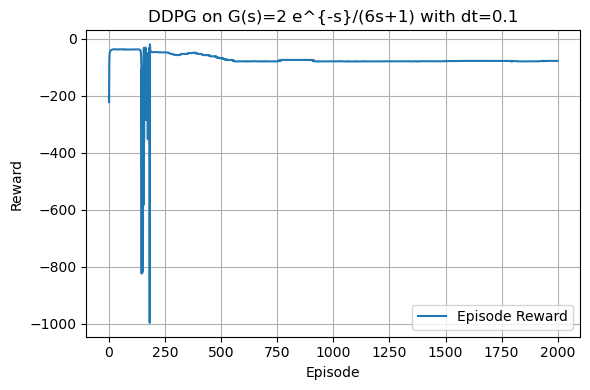

In [29]:
# putting all together
if __name__ == "__main__":
    # 1) Build a baseline PI controller with initial (Kp=0.2, Ki=0.05).
    #    We allow saturation ±2, plus a small anti-windup if you wish.
    base_pi = PIController(kp=0.2, ki=0.05, dt=0.1, 
                           umin=-2.0, umax=2.0, aw_gain=0.1)

    # 2) Create the environment (the delayed first-order system).
    env = PIDDelayEnv(base_pi, setpoint=1.0, total_time=20.0, dt=0.1)

    # 3) Train using DDPG
    rewards, steps, actor_net, critic_net = train_ddpg(env, 
                                                       max_episodes=2000,
                                                       actor_lr=1e-3, 
                                                       critic_lr=1e-3,
                                                       gamma=0.99, 
                                                       tau=0.005)

    # 4) Plot reward history
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.plot(rewards, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DDPG on G(s)=2 e^{-s}/(6s+1) with dt=0.1")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Simulation of continuous-time transfer function